# Evaluating the Model

### Install Requirements

In [1]:
%%capture

!pip install fiftyone
!pip install pyzbar
!pip install opencv-python
!pip install seaborn
!pip install openpyxl

### Import Required Libraries

In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.data.catalog import Metadata
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode

import os
import sys
import numpy as np
import pandas as pd
import fiftyone as fo
from PIL import Image, ImageOps
from PIL.ExifTags import TAGS
from pathlib import Path
from pyzbar.pyzbar import decode
from pyzbar.pyzbar import ZBarSymbol
from torchvision import transforms
from IPython.display import display


### Specify Model

There are several output folders from training multiple models.  

In [4]:
# set this to today's date
today = "2023-09-11"

# modify output folder suffix if needed
suffix = "kfold_train_2"

# name of output folder
output_folder = today + "_" + suffix

k=1

In [5]:
base_path = f"/home/jovyan/work/mask_rcnn/{output_folder}/fold_{k}/"

leaf_cfg = get_cfg()
leaf_cfg.MODEL.DEVICE='cpu'
leaf_cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
leaf_cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
leaf_cfg.MODEL.WEIGHTS = base_path + "model_final.pth" # path to trained weights
leaf_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set a custom testing threshold

leaf_predictor = DefaultPredictor(leaf_cfg)

# set up metadata
leaf_metadata = Metadata()
leaf_metadata.set(thing_classes = ['leaf', 'qr', 'red-square'])


   

[03/15 02:53:28 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/jovyan/work/mask_rcnn/2023-09-11_kfold_train_2/fold_1/model_final.pth ...


namespace(thing_classes=['leaf', 'qr', 'red-square'])

In [6]:
import numpy as np
from PIL import Image, ImageOps
import fiftyone as fo

# Assuming leaf_predictor is defined elsewhere and dataset is an iterable of samples
datasets = {}

for fold in range(1, 3):
    
    print(f'Loading fold {fold} into fiftyone dataset...')
    
    datasets[f'fold_{fold}'] = fo.Dataset.from_dir(
        data_path="/home/jovyan/work/data/",
        labels_path=f"/home/jovyan/work/mask_rcnn/{output_folder}/test_{fold}.json",
        dataset_type=fo.types.COCODetectionDataset, 
        name=f"{today}_fold_{fold}",
        label_types="segmentations",
        overwrite=True
    )
    
    print(f'Performing inference for fold {fold}...')

    with fo.ProgressBar() as pb:
        for sample in pb(datasets[f'fold_{fold}']):
            image = Image.open(sample.filepath)
            image = ImageOps.exif_transpose(image)  # Ensure correct orientation
            image_arr = np.array(image)
            h, w, _ = image_arr.shape

            outputs = leaf_predictor(image_arr)

            # Initialize counters for each class
            red_square_pixels, leaf_pixels, qr_pixels = 0, 0, 0
            detections = []

            for i, (mask, box, label, score) in enumerate(zip(outputs["instances"].pred_masks.numpy(),
                                                              outputs["instances"].pred_boxes.tensor.numpy(),
                                                              outputs["instances"].pred_classes.numpy(),
                                                              outputs["instances"].scores.numpy())):
                x1, y1, x2, y2 = box
                rel_box = [x1 / w, y1 / h, (x2 - x1) / w, (y2 - y1) / h]  # Relative bounding box

                bbox_mask = mask[round(y1):round(y2), round(x1):round(x2)]
                mask_pixel_count = np.count_nonzero(bbox_mask)

                class_label = ['leaf', 'qr', 'red-square'][label]

                # Update pixel counts based on class
                if class_label == 'leaf':
                    leaf_pixels += mask_pixel_count
                elif class_label == 'red-square':
                    red_square_pixels += mask_pixel_count  # Assuming you want to sum red square pixels
                elif class_label == 'qr':
                    qr_pixels += mask_pixel_count

                detections.append(fo.Detection(
                    label=class_label,
                    bounding_box=rel_box,
                    mask=bbox_mask,
                    confidence=score,
                    original_bbox=box
                ))

            # print(f'image: {sample.filepath}, red_square_pixels: {red_square_pixels}, leaf_pixels: {leaf_pixels}, qr_pixels: {qr_pixels}')

            # Calculate leaf area
            leaf_area = None
            if red_square_pixels:
                # Red square is 2cm x 2cm, or 4 cm2
                leaf_area = (4 * leaf_pixels) / red_square_pixels
            elif qr_pixels:
                 # QR is 1.2cm x 1.2cm, or 1.44 cm2
                leaf_area = (1.44 * leaf_pixels) / qr_pixels

            # if leaf_area is not None:
            #     print(f'leaf area: {leaf_area:.2f} cm2')

            # Update sample with detections and calculated area
            sample["predictions"] = fo.Detections(detections=detections)
            sample["height"] = h
            sample["width"] = w
            sample["area"] = leaf_area
            sample.save()


Loading fold 1 into fiftyone dataset...
 100% |███████████████████| 35/35 [8.6s elapsed, 0s remaining, 4.0 samples/s]      
Performing inference for fold 1...
   0% ||------------------|  0/35 [13.9ms elapsed, ? remaining, ? samples/s] 

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


 100% |███████████████████| 35/35 [1.2m elapsed, 0s remaining, 0.5 samples/s]     
Loading fold 2 into fiftyone dataset...
 100% |███████████████████| 35/35 [9.1s elapsed, 0s remaining, 3.2 samples/s]      
Performing inference for fold 2...
 100% |███████████████████| 35/35 [1.3m elapsed, 0s remaining, 0.4 samples/s]     


In [8]:
import numpy as np
import matplotlib.pyplot as plt

def convert_to_pixels(bbox, height, width):
    x1, y1, w, h = bbox
    return [x1 * width, y1 * height, (x1 + w) * width, (y1 + h) * height]

def calculate_mask(detections, height, width):
    mask = np.zeros((height, width), dtype=bool)
    for d in detections:
        if d.label == 'leaf':
            bbox = d.bounding_box
            x1, y1, x2, y2 = convert_to_pixels(bbox, height, width)
            mask[round(y1):round(y2), round(x1):round(x2)] |= d.mask
    return mask

def calculate_iou_and_dice(gt_mask, pred_mask):
    intersect = np.logical_and(gt_mask, pred_mask)
    union = np.logical_or(gt_mask, pred_mask)
    intersect_pixels = np.count_nonzero(intersect)
    union_pixels = np.count_nonzero(union)
    
    iou = intersect_pixels / union_pixels if union_pixels else None
    dice = (2 * intersect_pixels) / (np.count_nonzero(gt_mask) + np.count_nonzero(pred_mask)) if union_pixels else None
    
    return iou, dice

def visualize_masks(gt_mask, pred_mask):
    f, axarr = plt.subplots(1, 2)
    plt.rcParams['figure.figsize'] = [10, 10]
    axarr[0].title.set_text('Ground Truth')
    axarr[1].title.set_text('Prediction')
    axarr[0].imshow(gt_mask)
    axarr[1].imshow(pred_mask)
    plt.show()

In [10]:
import pandas as pd

# initialize dataframe from manual area file, and add column for ml_area
df = pd.read_excel('/home/jovyan/work/data/manual_area.xlsx')
df['ml_area'] = None
df['ml_area'] = df['ml_area'].astype(float)
df['ground_truth_pixels'] = None
df['ground_truth_pixels'] = df['ground_truth_pixels'].astype(float)
df['prediction_pixels'] = None
df['prediction_pixels'] = df['prediction_pixels'].astype(float)
df['iou'] = None
df['iou'] = df['iou'].astype(float)
df['dice'] = None
df['dice'] = df['dice'].astype(float)

missing_from_file = []

for fold_name, dataset in datasets.items():
    
    print('\n' + fold_name)
    print('---------------------------')
    
    fold_iou = []
    fold_dice = []

    for sample in dataset:

        filename = sample.filepath.split('/')[-1].split('.')[0]

        if not df.loc[df['picture'].str.startswith(filename)].empty:
            df.loc[df['picture'].str.startswith(filename), 'ml_area'] = float(round(sample.area, 2)) 
        else:
            missing_from_file.append(filename)
        
        height, width = sample.height, sample.width
        ground_truth_mask = calculate_mask(sample.ground_truth.detections, height, width)
        prediction_mask = calculate_mask(sample.predictions.detections, height, width)

        # print('Prediction pixel count: ', np.count_nonzero(prediction_mask))
        # print('Ground truth pixel count: ', np.count_nonzero(ground_truth_mask))

        iou, dice = calculate_iou_and_dice(ground_truth_mask, prediction_mask)
        
        df.loc[df['picture'].str.startswith(filename), 'ground_truth_pixels'] = np.count_nonzero(ground_truth_mask)
        df.loc[df['picture'].str.startswith(filename), 'prediction_pixels'] = np.count_nonzero(prediction_mask)
        df.loc[df['picture'].str.startswith(filename), 'iou'] = iou
        df.loc[df['picture'].str.startswith(filename), 'dice'] = dice 
        
        fold_iou.append(iou)
        fold_dice.append(dice)

        # visualize_masks(ground_truth_mask, prediction_mask)
    
    fold_iou = np.array(fold_iou, dtype=float)

    print('Min IOU: ', np.nanmin(fold_iou))
    print('Max IOU: ', np.nanmax(fold_iou))
    print('Average IOU: ', np.nanmean(fold_iou))

    print('\n')

    fold_dice = np.array(fold_dice, dtype=float)

    print('Min Dice: ', np.nanmin(fold_dice))
    print('Max Dice: ', np.nanmax(fold_dice))
    print('Average Dice: ', np.nanmean(fold_dice))


df_area = df[df['ml_area'] >= 0.0]

print('\n')
print(df_area)


fold_1
---------------------------
Min IOU:  0.0
Max IOU:  0.9154512203664602
Average IOU:  0.6456158233414965


Min Dice:  0.0
Max Dice:  0.9558596017823079
Average Dice:  0.7358327848587056

fold_2
---------------------------
Min IOU:  0.0
Max IOU:  0.9403406861737023
Average IOU:  0.7157493318937882


Min Dice:  0.0
Max Dice:  0.9692531758719423
Average Dice:  0.7744462553937949


          picture  area_cm2  ml_area  ground_truth_pixels  prediction_pixels  \
3    IMG_5795.tif      0.09     0.09              22142.0            20358.0   
5    IMG_5850.tif      0.91     0.51             249791.0           105124.0   
7    IMG_5852.tif      0.10     0.00              28006.0                0.0   
8    IMG_5853.tif      0.77     0.00             221062.0                0.0   
9    IMG_5854.tif      0.66     0.00             181261.0                0.0   
..            ...       ...      ...                  ...                ...   
160  IMG_6038.tif      6.05     5.13            1461

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


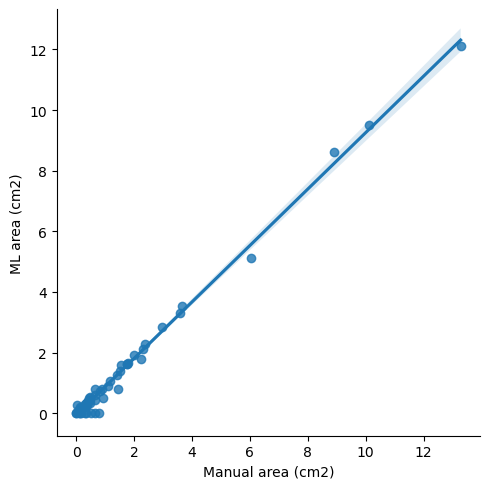

In [11]:
import seaborn as sns
plt = sns.lmplot(data=df_area, x='area_cm2', y='ml_area', fit_reg=True)
plt.set(xlabel='Manual area (cm2)', ylabel='ML area (cm2)')

In [12]:
df_area.corr(numeric_only=True)

,area_cm2,ml_area,ground_truth_pixels,prediction_pixels,iou,dice
area_cm2,1.000000,0.996405,0.966514,0.961959,0.301014,0.246962
ml_area,0.996405,1.000000,0.957132,0.959170,0.343049,0.291463
ground_truth_pixels,0.966514,0.957132,1.000000,0.995503,0.295543,0.239145
prediction_pixels,0.961959,0.959170,0.995503,1.000000,0.348846,0.296152
iou,0.301014,0.343049,0.295543,0.348846,1.000000,0.988568
dice,0.246962,0.291463,0.239145,0.296152,0.988568,1.000000


In [13]:
from scipy import stats

corr = stats.pearsonr(df_area.area_cm2, df_area.ml_area)
print(corr)
r_squared = corr.statistic * corr.statistic
print('r^2:', r_squared)

PearsonRResult(statistic=0.9964054448825971, pvalue=1.218990797277069e-74)
r^2: 0.9928238105916862


In [14]:
df_area.corr(method='pearson', numeric_only=True)

,area_cm2,ml_area,ground_truth_pixels,prediction_pixels,iou,dice
area_cm2,1.000000,0.996405,0.966514,0.961959,0.301014,0.246962
ml_area,0.996405,1.000000,0.957132,0.959170,0.343049,0.291463
ground_truth_pixels,0.966514,0.957132,1.000000,0.995503,0.295543,0.239145
prediction_pixels,0.961959,0.959170,0.995503,1.000000,0.348846,0.296152
iou,0.301014,0.343049,0.295543,0.348846,1.000000,0.988568
dice,0.246962,0.291463,0.239145,0.296152,0.988568,1.000000


In [15]:
df_area.corr(method='kendall', numeric_only=True)

,area_cm2,ml_area,ground_truth_pixels,prediction_pixels,iou,dice
area_cm2,1.000000,0.785138,0.928849,0.750789,0.416334,0.416334
ml_area,0.785138,1.000000,0.740572,0.943136,0.578163,0.578163
ground_truth_pixels,0.928849,0.740572,1.000000,0.762382,0.439054,0.439054
prediction_pixels,0.750789,0.943136,0.762382,1.000000,0.599069,0.599069
iou,0.416334,0.578163,0.439054,0.599069,1.000000,1.000000
dice,0.416334,0.578163,0.439054,0.599069,1.000000,1.000000


In [ ]:
session = fo.launch_app(dataset, port=5151, address="0.0.0.0")

In [ ]:
session.refresh()